<a href="https://colab.research.google.com/github/ygxrb/analises-vendas-ecommerce/blob/main/An%C3%A1lise_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set(rc={"figure.figsize":(12,6)})


#Importação e visualização dos dados

In [ ]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_product_category = pd.read_csv('product_category_name_translation.csv')

#Tratamento de dados
#Convertendo os valores das datas de int para datetime

In [ ]:
df_items["shipping_limit_date"] = pd.to_datetime(df_items["shipping_limit_date"])
print(df_items.dtypes)

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object


In [ ]:
df_reviews["review_creation_date"] = pd.to_datetime(df_reviews["review_creation_date"])
df_reviews["review_answer_timestamp"] = pd.to_datetime(df_reviews["review_answer_timestamp"])
print(df_reviews.dtypes)

review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object


In [ ]:
df_orders["order_delivered_carrier_date"] = pd.to_datetime(df_orders["order_delivered_carrier_date"])
df_orders["order_delivered_customer_date"] = pd.to_datetime(df_orders["order_delivered_customer_date"])
df_orders["order_estimated_delivery_date"] = pd.to_datetime(df_orders["order_estimated_delivery_date"])

print(df_orders.dtypes)

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp                 object
order_approved_at                        object
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


#verificando se existe algum valor nulo em 'price' e 'freight_value'

In [ ]:
df_items.isnull().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0


#Agrupando as colunas mais importantes


In [ ]:
#receita total do pedido (soma dos itens + frete)
df_items_agg = df_items.groupby("order_id").agg({
    "price": "sum",
    "freight_value": "sum"
}).reset_index()



df_payments_agg = df_payments.groupby("order_id").agg({
    "payment_value": "sum"
}).reset_index()


In [ ]:
#calcular a média da nota por pedido
df_reviews_agg = df_reviews.groupby("order_id").agg({
    "review_score": "mean"
}).reset_index()

#arredondando para 1 casa decimal
df_reviews_agg["review_score"] = df_reviews_agg["review_score"].round(1)

In [ ]:
#orders + items + payments + reviews
df_orders_full = (
    df_orders
    .merge(df_items_agg, on="order_id", how="left")
    .merge(df_payments_agg, on="order_id", how="left")
    .merge(df_reviews_agg[["order_id","review_score"]], on="order_id", how="left")
)

In [ ]:
# Mesclando df_orders_full com df_customers em 'customer_id' para adicionar 'customer_state'
df_orders_full = df_orders_full.merge(df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')

In [ ]:
# Mesclando df_items com df_products para obter o nome da categoria do produto
df_items_products = df_items.merge(df_products[["product_id", "product_category_name"]], on="product_id", how="left")

# Mesclando o resultado com df_orders_full
df_orders_full = df_orders_full.merge(df_items_products[["order_id", "product_category_name"]], on="order_id", how="left")


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,payment_value,review_score,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,8.72,38.71,4.0,utilidades_domesticas
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,22.76,141.46,4.0,perfumaria
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,19.22,179.12,5.0,automotivo
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,27.20,72.20,5.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,8.72,28.62,5.0,papelaria


In [ ]:
display(df_customers.head())
display(df_geolocation.head())
display(df_items_agg.head())
display(df_payments_agg.head())
display(df_reviews_agg.head())
display(df_orders_full.head())
display(df_products.head())
display(df_sellers.head())
display(df_product_category.head())

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14


,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


,order_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,payment_value,review_score,product_category_name,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,8.72,38.71,4.0,utilidades_domesticas,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,22.76,141.46,4.0,perfumaria,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,19.22,179.12,5.0,automotivo,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,27.20,72.20,5.0,pet_shop,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,8.72,28.62,5.0,papelaria,SP


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


#Criando KPI's

In [ ]:
total_revenue = df_orders_full.groupby("order_id")["price"].sum()
print(total_revenue)

order_id
00010242fe8c5a6d1ba2dd792cb16214     58.90
00018f77f2f0320c557190d7a144bdd3    239.90
000229ec398224ef6ca0657da4fc703e    199.00
00024acbcdf0a6daa1e931b038114c75     12.99
00042b26cf59d7ce69dfabb4e55b4fd9    199.90
                                     ...  
fffc94f6ce00a00581880bf54a75a037    299.99
fffcd46ef2263f404302a634eb57f7eb    350.00
fffce4705a9662cd70adb13d4a31832d     99.90
fffe18544ffabc95dfada21779c9644f     55.99
fffe41c64501cc87c801fd61db3f6244     43.00
Name: price, Length: 99441, dtype: float64


In [ ]:
net_profit = df_orders_full.groupby("order_id")["payment_value"].sum()
print(net_profit)

order_id
00010242fe8c5a6d1ba2dd792cb16214     72.19
00018f77f2f0320c557190d7a144bdd3    259.83
000229ec398224ef6ca0657da4fc703e    216.87
00024acbcdf0a6daa1e931b038114c75     25.78
00042b26cf59d7ce69dfabb4e55b4fd9    218.04
                                     ...  
fffc94f6ce00a00581880bf54a75a037    343.40
fffcd46ef2263f404302a634eb57f7eb    386.53
fffce4705a9662cd70adb13d4a31832d    116.85
fffe18544ffabc95dfada21779c9644f     64.71
fffe41c64501cc87c801fd61db3f6244     55.79
Name: payment_value, Length: 99441, dtype: float64


In [ ]:
ticket_medio = df_orders_full.groupby("order_id")["payment_value"].sum().mean()
print(ticket_medio)

160.98864774087147


In [ ]:
total_orders = df_orders_full["order_id"].nunique()
print(total_orders)

99441


In [ ]:
unique_customers = df_customers["customer_unique_id"].nunique()
print(unique_customers)

96096


In [ ]:
active_sellers = df_sellers["seller_id"].nunique()
print(active_sellers)

3095


In [ ]:
average_rating = df_orders_full ["review_score"].mean()
print(average_rating)

4.086792739655224


In [ ]:
df_orders_full["order_delivered_customer_date"] = pd.to_datetime(df_orders_full["order_delivered_customer_date"])
df_orders_full["order_purchase_timestamp"] = pd.to_datetime(df_orders_full["order_purchase_timestamp"])
df_orders_full["tempo_entrega"] = (df_orders_full["order_delivered_customer_date"] - df_orders_full["order_purchase_timestamp"]).dt.days
df_orders_full["tempo_entrega"].mean()

print(df_orders_full["tempo_entrega"].mean())


12.094085575687217


#Criando a relaçao Tempo de Entrega X Avaliação

In [ ]:
df_orders_full["order_purchase_timestamp"] = pd.to_datetime(df_orders_full["order_purchase_timestamp"])
df_orders_full["order_delivered_customer_date"] = pd.to_datetime(df_orders_full["order_delivered_customer_date"])

# Ano e mês
df_orders_full["ano"] = df_orders_full["order_purchase_timestamp"].dt.year
df_orders_full["mes"] = df_orders_full["order_purchase_timestamp"].dt.month
df_orders_full["ano_mes"] = df_orders_full["order_purchase_timestamp"].dt.to_period("M")

# Tempo de entrega
df_orders_full["tempo_entrega"] = (df_orders_full["order_delivered_customer_date"] - df_orders_full["order_purchase_timestamp"]).dt.days


#Criando e visualizando o dataset final

In [ ]:
df_orders_full.to_csv('df_orders_full.csv', index=False)


In [ ]:
df = pd.read_csv("df_orders_full.csv")

In [ ]:
df.info()
df.head()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   price                          98666 non-null  float64
 9   freight_value                  98666 non-null  float64
 10  payment_value                  99440 non-null  float64
 11  review_score                   98673 non-null  float64
 12  tempo_entrega                  96476 non-null 

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0
price,775
freight_value,775


In [ ]:
print("Receita total:", df_orders_full["payment_value"].sum())
print("Pedidos únicos:", df_orders_full["order_id"].nunique())
print("Clientes únicos:", df_orders_full["customer_id"].nunique())
print("Ticket médio:", df_orders_full.groupby("order_id")["payment_value"].sum().mean())
print("Tempo médio entrega (dias):", df_orders_full["tempo_entrega"].mean())
print("Média review_score:", df_orders_full["review_score"].mean())

Receita total: 16008872.120000001
Pedidos únicos: 99441
Clientes únicos: 99441
Ticket médio: 160.98864774087147
Tempo médio entrega (dias): 12.094085575687217
Média review_score: 4.086792739655224


#Gráficos essenciais

#Receita Mensal


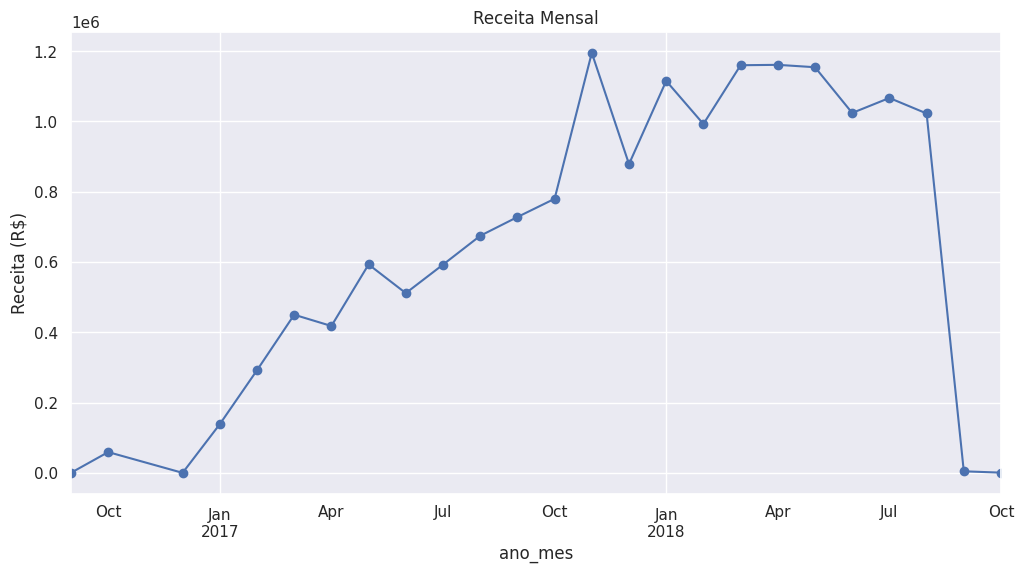

In [ ]:
df_orders_full.groupby("ano_mes")["payment_value"].sum().plot(kind="line", marker="o")
plt.title("Receita Mensal")
plt.ylabel("Receita (R$)")
plt.show()

#Pedidos Mensais

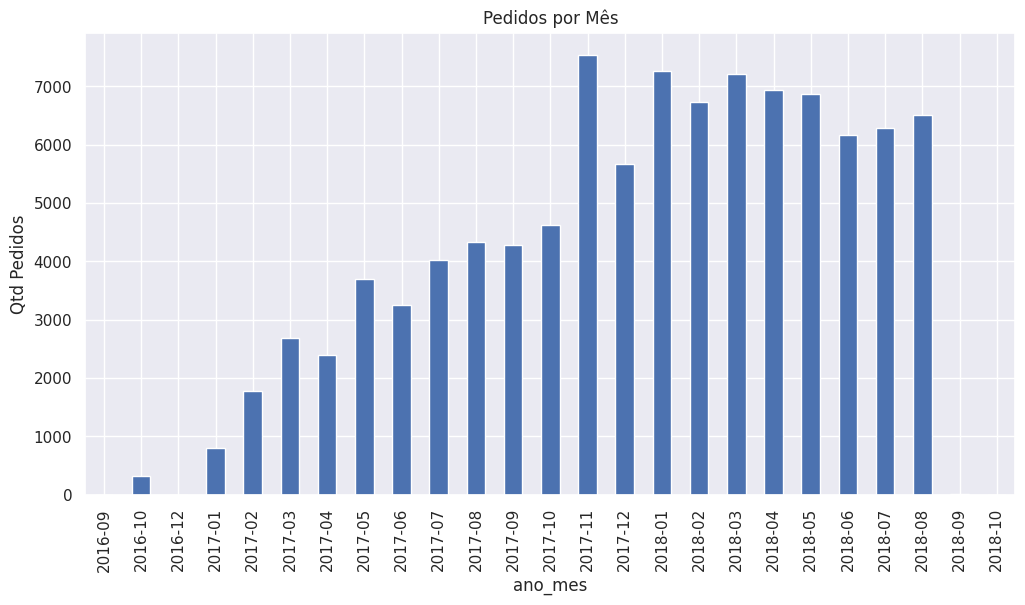

In [ ]:
df_orders_full.groupby("ano_mes")["order_id"].nunique().plot(kind="bar")
plt.title("Pedidos por Mês")
plt.ylabel("Qtd Pedidos")
plt.show()

#Ticket Médio Mensal


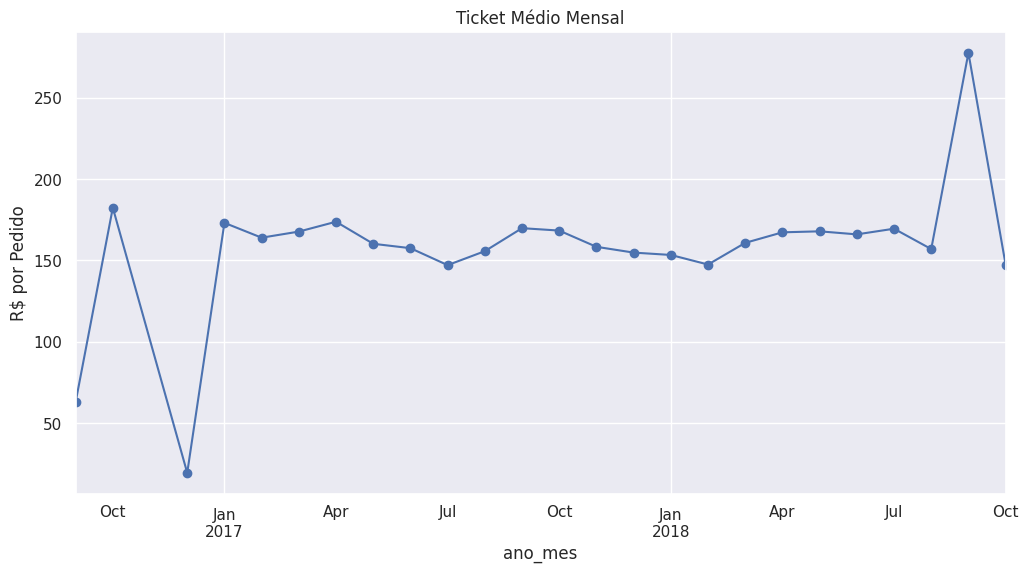

In [ ]:
ticket_mensal = df_orders_full.groupby("ano_mes")["payment_value"].sum() / df_orders_full.groupby("ano_mes")["order_id"].nunique()
ticket_mensal.plot(kind="line", marker="o")
plt.title("Ticket Médio Mensal")
plt.ylabel("R$ por Pedido")
plt.show()


#Top Categorias por Receita

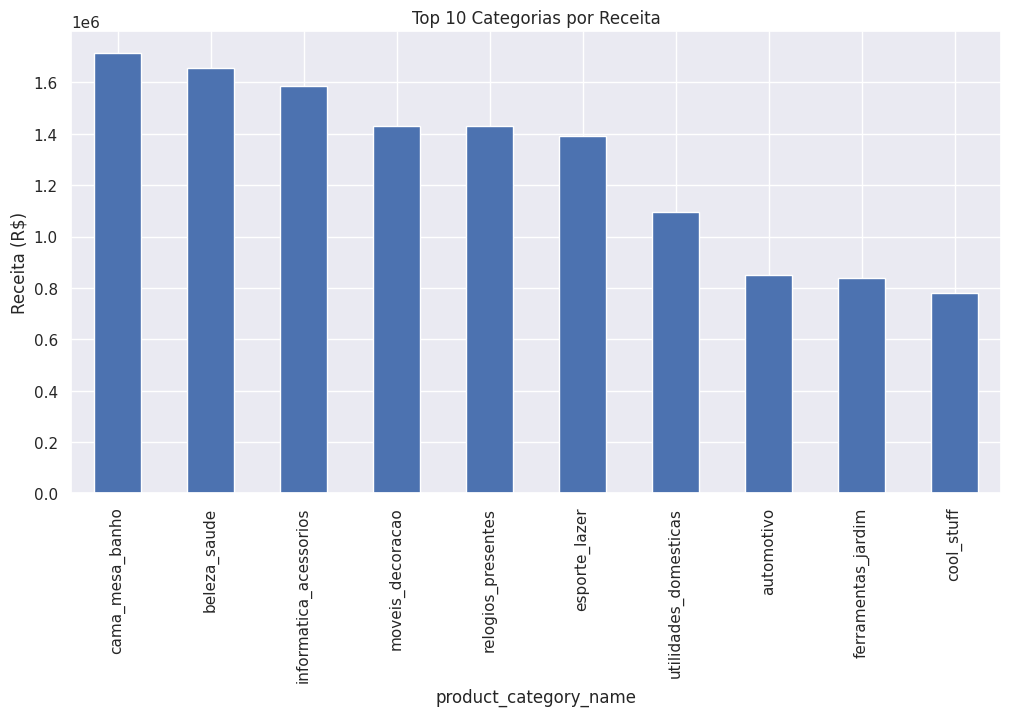

In [ ]:
df_orders_full.groupby("product_category_name")["payment_value"].sum().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Categorias por Receita")
plt.ylabel("Receita (R$)")
plt.show()


#Média de Avaliações

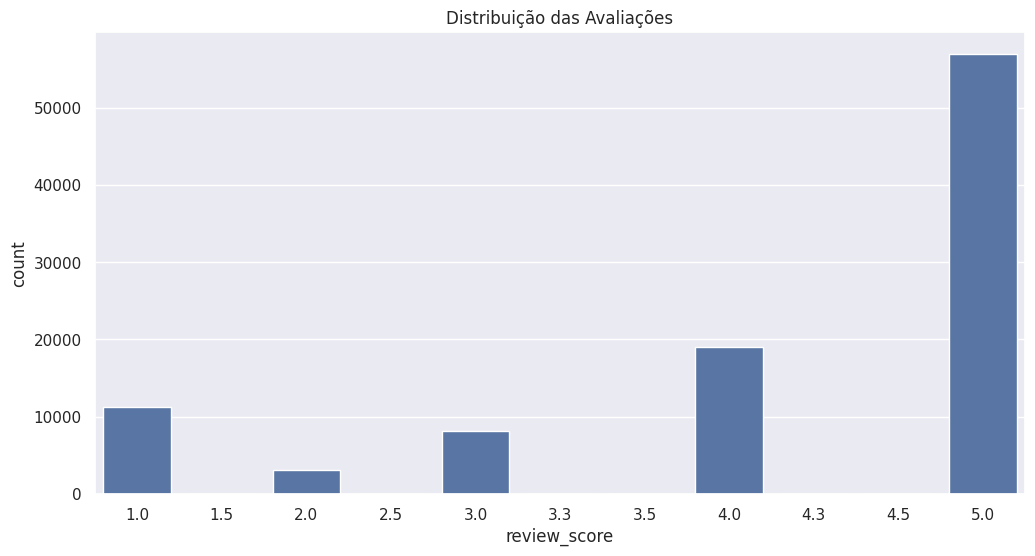

In [ ]:
sns.countplot(x="review_score", data=df)
plt.title("Distribuição das Avaliações")
plt.show()


#Relação Tempo de Entrega x Nota de Avaliação

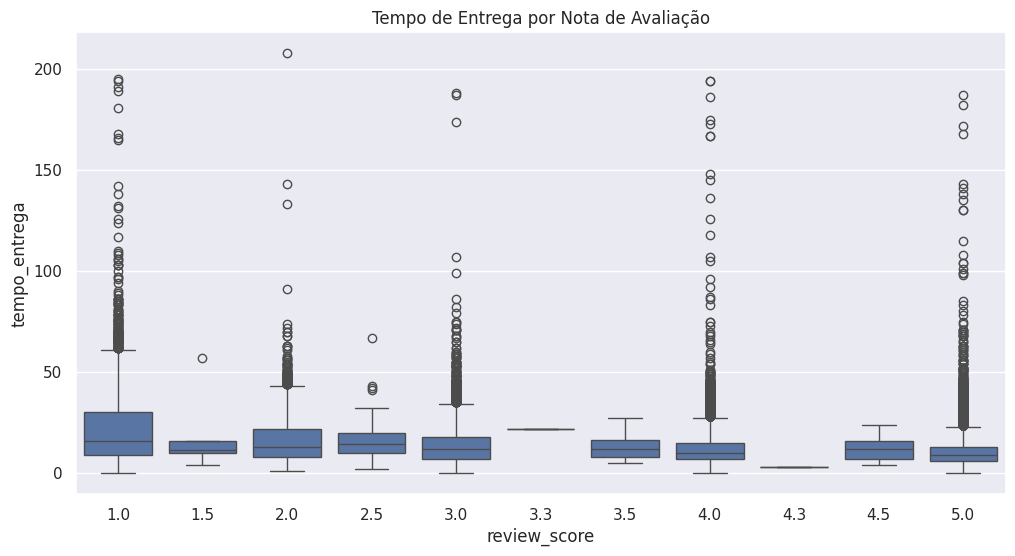

In [ ]:
sns.boxplot(x="review_score", y="tempo_entrega", data=df)
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.show()


#Receita por Estado

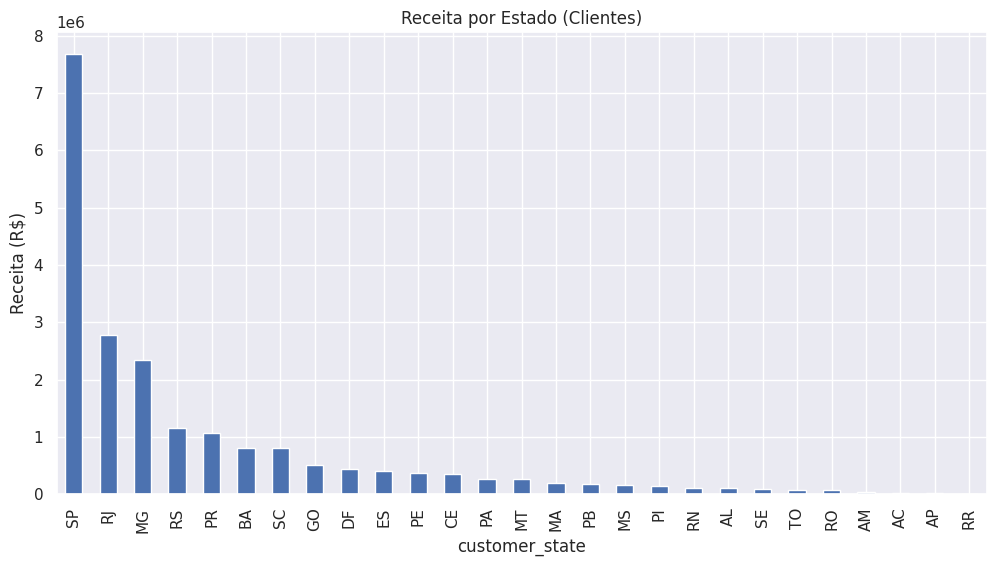

In [ ]:
df_orders_full.groupby("customer_state")["payment_value"].sum().sort_values(ascending=False).plot(kind="bar")
plt.title("Receita por Estado (Clientes)")
plt.ylabel("Receita (R$)")
plt.show()